In [1]:
from sklearn.datasets import load_wine
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
wine = load_wine()
dsTargetNames = ['female','male']
dsTargetNames

['female', 'male']

In [3]:
df = pd.read_csv("trainingSetLDA.csv") 
df.head()

,Height,Weight,ShoeSize,Label
0,174.349910,61.650229,39.510609,female
1,164.935084,59.997600,38.733729,female
2,160.013237,64.090579,41.050770,female
3,164.167748,62.141069,45.760832,female
4,164.501485,47.480263,38.060959,female


In [4]:
X = df[["Height", "Weight","ShoeSize"]]
X

,Height,Weight,ShoeSize
0,174.349910,61.650229,39.510609
1,164.935084,59.997600,38.733729
2,160.013237,64.090579,41.050770
3,164.167748,62.141069,45.760832
4,164.501485,47.480263,38.060959
...,...,...,...
9995,169.493128,55.953592,45.142210
9996,173.733329,65.211794,51.194405
9997,174.645909,67.584361,45.765471
9998,171.147090,64.835397,39.094836


In [5]:
y = df["Label"]
y

0       female
1       female
2       female
3       female
4       female
         ...  
9995      male
9996      male
9997      male
9998      male
9999      male
Name: Label, Length: 10000, dtype: object

In [6]:
class_feature_means = pd.DataFrame(columns=dsTargetNames)
for c, rows in df.groupby('Label'):
    class_feature_means[c] = rows.mean()
class_feature_means

,female,male
Height,162.082808,169.926370
Weight,60.020093,64.889293
ShoeSize,37.923279,42.027072


In [7]:
within_class_scatter_matrix = np.zeros((3,3))
for c, rows in df.groupby('Label'):
    rows = rows.drop(['Label'], axis=1)
    s = np.zeros((3,3))
    for index, row in rows.iterrows():
        x, mc = row.values.reshape(3,1), class_feature_means[c].values.reshape(3,1)
        
        s += (x - mc).dot((x - mc).T)
    
    within_class_scatter_matrix += s

In [8]:
within_class_scatter_matrix

array([[244863.292 ,    738.394 ,   1058.113 ],
       [   738.394 , 245613.5014,    926.7371],
       [  1058.113 ,    926.7371, 248471.4854]])

In [9]:
feature_means = df.mean()
between_class_scatter_matrix = np.zeros((3,3))
for c in class_feature_means:    
    n = len(df.loc[df['Label'] == c].index)
    
    mc, m = class_feature_means[c].values.reshape(3,1), feature_means.values.reshape(3,1)
    
    between_class_scatter_matrix += n * (mc - m).dot((mc - m).T)

In [10]:
between_class_scatter_matrix

array([[153803.6534,  95479.6808,  80470.8917],
       [ 95479.6808,  59272.7757,  49955.4782],
       [ 80470.8917,  49955.4782,  42102.7997]])

In [11]:
eigen_values, eigen_vectors = np.linalg.eig(np.linalg.inv(within_class_scatter_matrix).dot(between_class_scatter_matrix))

In [12]:
pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
pairs = sorted(pairs, key=lambda x: x[0], reverse=True)
for pair in pairs:
    print(pair[0])

1.0322855008876566
4.90222200287188e-17
4.90222200287188e-17


In [13]:
eigen_value_sums = sum(eigen_values)
print('Explained Variance')
for i, pair in enumerate(pairs):
    print('Eigenvector {}: {}'.format(i, (pair[0]/eigen_value_sums).real))

Explained Variance
Eigenvector 0: 1.0
Eigenvector 1: 4.74890134430493e-17
Eigenvector 2: 4.74890134430493e-17


# eigenvectors 1 and 2 are negligible. That explains why :(

In [14]:
#pick the first two vectors (0 and 1), because we want to reduce from 3 dimensions to 2
w_matrix = np.hstack((pairs[0][1].reshape(3,1), pairs[1][1].reshape(3,1))).real

In [20]:
X_lda = np.array(X.dot(w_matrix))
X_lda

array([[181.5195,  42.1578],
       [173.0655,  38.7759],
       [172.1177,  34.7916],
       ...,
       [187.1016,  37.185 ],
       [180.3864,  41.1367],
       [185.0741,  39.9787]])

In [19]:
df['numLabels'] = np.where(df['Label'].isin(['male']), 1., 0.)

,Height,Weight,ShoeSize,Label,numLabels
0,174.349910,61.650229,39.510609,female,0.0
1,164.935084,59.997600,38.733729,female,0.0
2,160.013237,64.090579,41.050770,female,0.0
3,164.167748,62.141069,45.760832,female,0.0
4,164.501485,47.480263,38.060959,female,0.0


In [21]:
plotDF = pd.DataFrame(X_lda, columns=['LD1','LD2'])
plotDF.head()

,LD1,LD2
0,181.519533,42.157759
1,173.065538,38.775891
2,172.117728,34.791622
3,176.301681,32.713392
4,166.435401,39.121380


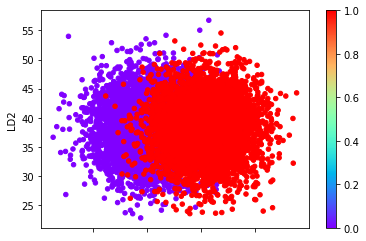

In [23]:
plotDF.plot.scatter(x='LD1',y='LD2', c=df['numLabels'], colormap = 'rainbow')